In [68]:
# Adjoint SWE Solver (v28‑12)

%reload_ext autoreload 
# enables automatic reloading of modules before executing code
%autoreload 2 
# set to reload all modules (except those excluded by %aimport) every time before executing the Python code typed
import sys
print("System path:", sys.executable)
print("Python version:", sys.version)


# --- Python core packages ---
import numpy as np
import matplotlib.pyplot as plt

# --- FEniCS core ---
import dolfin as dlf
from dolfin import (
    Constant, Function, FunctionSpace, VectorFunctionSpace, 
    TestFunctions, TrialFunctions, Expression, interpolate, assign
)

# --- dolfin-adjoint (import early so wrappers are active before constants/functions are created) ---
from dolfin_adjoint import *

# --- UFL symbolic tools ---
import ufl
from ufl import dot, div, grad, nabla_grad, sqrt, inner, derivative, Measure

# --- PETSc bindings for parallel linear algebra ---
from petsc4py import PETSc

# --- project-specific mesh/BC setup ---
from Adjoint_optimisation.set_up_mesh import *       # defines `mesh`
from Adjoint_optimisation.set_up_bcs import *        # defines `bcs`
from Adjoint_optimisation.place_turbines_random import *   #defintes "initial placement"

print("✅ Thesis adjoint SWE solver ready (v28-12)")

System path: /home/zabreedveld/miniconda3/envs/fenicsproject/bin/python
Python version: 3.10.19 | packaged by conda-forge | (main, Oct 22 2025, 22:29:10) [GCC 14.3.0]
✅ Thesis adjoint SWE solver ready (v28-12)


Parameters:

In [69]:
# Step 2 — Base physical & numerical parameters
# Define constants and parameters for the SWE model
# --- Physical constants ---
rho  = Constant(1025.0)     # density [kg/m³]
g    = Constant(9.81)       # gravity [m/s²]
nu   = Constant(1.0)        # eddy viscosity [m²/s]
h0   = Constant(40.0)       # mean depth [m]
# --- Turbine and drag coefficients ---
C_T = 0.7                   # thrust coefficient
C_D = 0.0025                # background drag coefficient
D = 5.0                     # turbine diameter [m]
sigma = 0.5*D               # gaussian width [m]
A_T = np.pi * D**2          # turbine swept area [m²]

# --- Flow and boundary data ---
U_inflow = 2.0              # deth-averaged inflow velocity [m/s]
initial_condition_u = Constant((0.0, 0.0))  # initial velocity field
initial_condition_eta = Constant(0.0)       # initial free surface elevation

# --- Domain size and mesh resolution ---
Lx, Ly = 500.0, 400.0    # domain dimensions [m]
Nx, Ny = 50, 40          # mesh resolution

# --- Turbine layout parameters ---
n_turbines = 15 # number of turbines
min_spacing = 5 * D # minimum spacing between turbines [m]

# --- Plot toggles ---
show_mesh_plot = True # toggle to plot the mesh

print(f"✅ Base parameters initialized successfully, Zoë.")


✅ Base parameters initialized successfully, Zoë.


Building mesh, inserting boundary conditions and initial placement of turbines

Mesh and mixed space initialised.


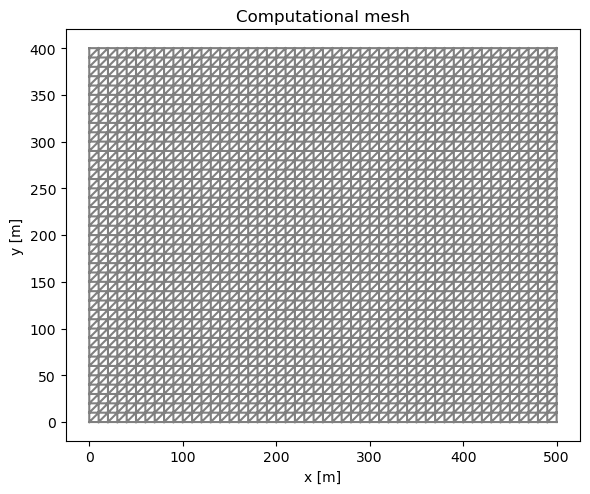

Boundary markers created and BCs applied:
   - Inlet  (ID=1): inflow velocity = 2.00 m/s
   - Outlet (ID=2): open boundary (no Dirichlet BC)
   - Walls  (ID=3): free‑slip (no Dirichlet BC)

Managed to place  15  turbines within  15  attempts.


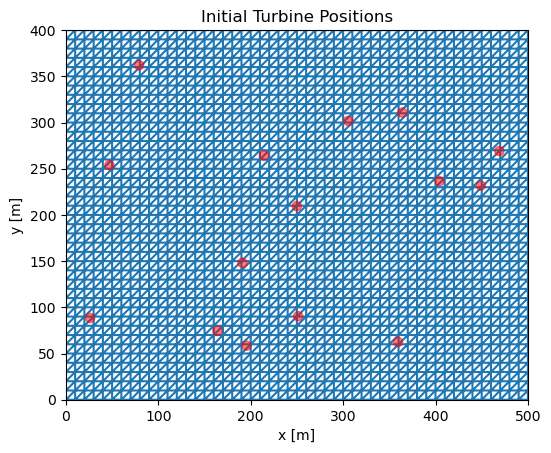

the initial turbine positions are: [[164.10496824  74.50292072]
 [191.06111691 148.15396483]
 [305.56880008 301.73392473]
 [448.9902111  231.71147913]
 [ 79.30751481 361.94429449]
 [251.35356205  90.40570481]
 [ 47.05461381 253.8418768 ]
 [249.92177943 209.51901033]
 [364.02763781 310.81467495]
 [214.39319401 264.25453704]
 [359.45499007  62.53161387]
 [404.24258146 236.53413042]
 [ 26.16786169  88.48276507]
 [195.36309921  58.49366427]
 [469.10432052 269.11703026]]


In [82]:
mesh, W, w, u, eta, v, q = mesh_set_up(Lx, Ly, Nx, Ny, show_mesh_plot)
boundary_markers, bcs = setup_boundary_markers_and_bcs(mesh, W, Lx, Ly, U_inflow)
initial_positions = place_turbines_random2(mesh, Lx, Ly, n_turbines, min_spacing, D, mesh)
print("the initial turbine positions are:", initial_positions)

In [73]:
import dolfin_adjoint as adj
from ufl import derivative

# 1️⃣ use a Dolfin Jacobian with a mixed TrialFunction so shape matches w
J_F = dlf.derivative(F, w, dlf.TrialFunction(W))   # proper dolfin Form

# 2️⃣ ensure annotation is active
try:
    adj.continue_annotation()
except Exception:
    pass

# 3️⃣ build and solve (standard solver)
print('tape blocks before solve:', len(adj.get_working_tape()._blocks))
problem = dlf.NonlinearVariationalProblem(F, w, bcs, J=J_F)
solver  = dlf.NonlinearVariationalSolver(problem)

solver.parameters["newton_solver"]["linear_solver"] = "mumps"
solver.parameters["newton_solver"]["absolute_tolerance"] = 1e-8
solver.parameters["newton_solver"]["relative_tolerance"] = 1e-7

# Print BC diagnostics
print('BCs:', [(type(bc), hasattr(bc, 'block_variable'), hasattr(bc, '_ad_will_add_as_dependency')) for bc in bcs])

solver.solve()
print('✅ Forward SWE solve complete.')
print('tape blocks after solve:', len(adj.get_working_tape()._blocks))

# -------------------
# Objective Functional (assemble *after* solve)
# -------------------
# wrap the solved state into a dolfin-adjoint Function so it provides required methods
try:
    w_wrapped = adj.Function(w)  # wrap existing Function if possible
except Exception:
    w_wrapped = adj.Function(W, name='w')
    dlf.assign(w_wrapped, w)

# Use the wrapped state's velocity component for J_form
u, eta_wrapped = dlf.split(w_wrapped)
# ensure dx uses the current mesh
new_dx = ufl.Measure("dx", domain=mesh)
J_form = 0.5 * inner(u, u) * new_dx

# assemble with adj so the operation is recorded on the tape
J = adj.assemble(J_form)

# -------------------
# Adjoint / gradient
# -------------------
m = adj.Control(cb)
rf = adj.ReducedFunctional(J, m)

print('Computing gradient (this will evaluate the adjoint)')
grad = rf.derivative()
print('Adjoint gradient computed.')

tape blocks before solve: 4
BCs: [(<class 'dolfin.fem.dirichletbc.DirichletBC'>, False, False)]
Solving nonlinear variational problem.
  Newton iteration 0: r (abs) = 1.411e-09 (tol = 1.000e-08) r (rel) = 1.000e+00 (tol = 1.000e-07)
  Newton solver finished in 0 iterations and 0 linear solver iterations.
✅ Forward SWE solve complete.
tape blocks after solve: 4
Computing gradient (this will evaluate the adjoint)


AttributeError: 'float' object has no attribute '_cpp_object'

In [67]:
print("F type:", type(F))
print("unknown type:", type(w))

print(type(w))
print(type(v))
print(type(F))

print(type(V_ctrl))
print(type(cb))

print("cb type:", type(cb))
print("F type:", type(F))
print("grad type:", type(grad))

print("mesh type:", type(mesh))
print(mesh)

print("w:", type(w))
print("u:", type(u))
print("eta:", type(eta))
print("v:", type(v))

(v, q) = TestFunctions(W)
print("v:", type(v))


F type: <class 'ufl.form.Form'>
unknown type: <class 'dolfin.function.function.Function'>
<class 'dolfin.function.function.Function'>
<class 'ufl.tensors.ListTensor'>
<class 'ufl.form.Form'>
<class 'dolfin.function.functionspace.FunctionSpace'>
<class 'fenics_adjoint.types.function.Function'>
cb type: <class 'fenics_adjoint.types.function.Function'>
F type: <class 'ufl.form.Form'>
grad type: <class 'function'>
mesh type: <class 'module'>
<module 'fenics_adjoint.types.mesh' from '/home/zabreedveld/miniconda3/envs/fenicsproject/lib/python3.10/site-packages/fenics_adjoint/types/mesh.py'>
w: <class 'dolfin.function.function.Function'>
u: <class 'ufl.tensors.ListTensor'>
eta: <class 'ufl.indexed.Indexed'>
v: <class 'ufl.tensors.ListTensor'>
v: <class 'ufl.tensors.ListTensor'>


In [60]:
# Diagnostic: inspect J_form.coefficients() without calling adj.assemble
J_form = 0.5 * inner(u, u) * dx
coeffs = J_form.coefficients()
print('number of coefficients in J_form:', len(coeffs))
for i, c in enumerate(coeffs):
    print('\nCoeff', i, type(c))
    try:
        print('  repr:', repr(c))
    except Exception:
        pass
    for attr in ['block_variable', '_ad_will_add_as_dependency', 'function_space', 'name']:
        print('  has', attr, getattr(c, '__dict__', 'N/A') if hasattr(c, attr) and attr!='name' else ('  has ' + attr + ': ' + str(hasattr(c, attr))))
    try:
        print('  function_space:', c.function_space())
    except Exception as e:
        print('  function_space access failed:', e)
    try:
        print('  is_control?', isinstance(c, adj.Control))
    except Exception:
        pass

number of coefficients in J_form: 1

Coeff 0 <class 'dolfin.function.function.Function'>
  repr: Coefficient(FunctionSpace(Mesh(VectorElement(FiniteElement('Lagrange', triangle, 1), dim=2), 263), MixedElement(VectorElement(FiniteElement('Lagrange', triangle, 2), dim=2), FiniteElement('Lagrange', triangle, 1))), 268)
  has block_variable   has block_variable: False
  has _ad_will_add_as_dependency   has _ad_will_add_as_dependency: False
  has function_space {'_cpp_object': <dolfin.cpp.function.Function object at 0x7fc9f85c49f0>, '_count': 268, '_ufl_function_space': FunctionSpace(Mesh(VectorElement(FiniteElement('Lagrange', triangle, 1), dim=2), 263), MixedElement(VectorElement(FiniteElement('Lagrange', triangle, 2), dim=2), FiniteElement('Lagrange', triangle, 1))), '_ufl_shape': (3,), '_repr': "Coefficient(FunctionSpace(Mesh(VectorElement(FiniteElement('Lagrange', triangle, 1), dim=2), 263), MixedElement(VectorElement(FiniteElement('Lagrange', triangle, 2), dim=2), FiniteElement('Lagra

In [81]:
# -------------------
# Objective Functional (assemble *after* solve)
# -------------------
# Import get_working_tape (compatibility across dolfin-adjoint versions)
try:
    from dolfin_adjoint import get_working_tape
except Exception:
    # older/newer packaging fallback
    from dolfin_adjoint.tape import get_working_tape

import dolfin_adjoint as adj

print("Tape blocks:", len(get_working_tape()._blocks))

# Diagnostic: ensure `dx` uses the wrapped mesh and not a previously-created raw mesh
print("mesh type:", type(mesh), "has _ad_will_add_as_dependency:", hasattr(mesh, '_ad_will_add_as_dependency'))
try:
    print("old dx domain:", dx.ufl_domain())
except Exception as e:
    print("old dx domain access failed:", e)

# Recreate dx measure so it points to the current (wrapped) mesh
dx = ufl.Measure("dx", domain=mesh)
print("new dx domain:", dx.ufl_domain())

J_form = 0.5 * inner(u, u)*dx        # e.g. measure kinetic energy
J = adj.assemble(J_form)                 # scalar value recorded on tape

# -------------------
# Adjoint / gradient
# -------------------
m = adj.Control(cb)
rf = adj.ReducedFunctional(J, m)
grad = rf.derivative()

print("Adjoint gradient computed.")
print("grad type:", type(grad))

# Try a quick diagnostic: report a norm if grad is a Function
try:
    gnorm = dlf.sqrt(dlf.assemble(dlf.inner(grad, grad) * dx))
    print("grad norm:", float(gnorm))
except Exception as e:
    print("Could not compute grad norm:", e)

Tape blocks: 6
mesh type: <class 'module'> has _ad_will_add_as_dependency: False
old dx domain: <Mesh #334>
Invalid cell <module 'fenics_adjoint.types.mesh' from '/home/zabreedveld/miniconda3/envs/fenicsproject/lib/python3.10/site-packages/fenics_adjoint/types/mesh.py'>.


ERROR:UFL:Invalid cell <module 'fenics_adjoint.types.mesh' from '/home/zabreedveld/miniconda3/envs/fenicsproject/lib/python3.10/site-packages/fenics_adjoint/types/mesh.py'>.


UFLException: Invalid cell <module 'fenics_adjoint.types.mesh' from '/home/zabreedveld/miniconda3/envs/fenicsproject/lib/python3.10/site-packages/fenics_adjoint/types/mesh.py'>.

In [80]:
# Diagnostic: inspect dolfin_adjoint for mesh-wrap utilities and test wrapping
import dolfin_adjoint as adj
print('adj functions containing "mesh" or "annot" or "wrap":')
for name in dir(adj):
    if 'mesh' in name.lower() or 'annot' in name.lower() or 'wrap' in name.lower():
        print(' -', name)

print('\nHas mesh _ad_will_add_as_dependency before wrap:', hasattr(mesh, '_ad_will_add_as_dependency'))

# Try common wrapping patterns
wrap_candidates = ['Mesh', 'annotate', 'annotation', 'wrap']
for cand in wrap_candidates:
    if hasattr(adj, cand):
        print('Found', cand, 'in adj; trying to call it on mesh')
        try:
            wrapped = getattr(adj, cand)(mesh)
            print(' -> wrapper returned type:', type(wrapped))
            print(' -> wrapped has _ad_will_add_as_dependency:', hasattr(wrapped, '_ad_will_add_as_dependency'))
        except Exception as e:
            print(' -> call failed:', e)
    else:
        print('No', cand, 'in adj')

# As fallback, try using adj.annotate on the mesh if available
if hasattr(adj, 'annotate'):
    try:
        adj.annotate(mesh)
        print('adj.annotate(mesh) succeeded')
        print('mesh _ad_will_add_as_dependency now:', hasattr(mesh, '_ad_will_add_as_dependency'))
    except Exception as e:
        print('adj.annotate(mesh) failed:', e)


adj functions containing "mesh" or "annot" or "wrap":
 - BoundaryMesh
 - BoxMesh
 - IntervalMesh
 - Mesh
 - RectangleMesh
 - SubMesh
 - UnitCubeMesh
 - UnitIntervalMesh
 - UnitSquareMesh
 - continue_annotation
 - mesh
 - pause_annotation
 - stop_annotating

Has mesh _ad_will_add_as_dependency before wrap: False
Found Mesh in adj; trying to call it on mesh
 -> call failed: __init__(): incompatible constructor arguments. The following argument types are supported:
    1. dolfin.cpp.mesh.Mesh()
    2. dolfin.cpp.mesh.Mesh(arg0: str)
    3. dolfin.cpp.mesh.Mesh(arg0: dolfin.cpp.mesh.Mesh)
    4. dolfin.cpp.mesh.Mesh(arg0: MPICommWrapper)
    5. dolfin.cpp.mesh.Mesh(arg0: MPICommWrapper, arg1: str)

Invoked with: <module 'fenics_adjoint.types.mesh' from '/home/zabreedveld/miniconda3/envs/fenicsproject/lib/python3.10/site-packages/fenics_adjoint/types/mesh.py'>
No annotate in adj
No annotation in adj
No wrap in adj


In [77]:
# Re-run the forward solve with the dolfin-adjoint wrapper `solve` so it is recorded on the tape
from dolfin_adjoint import *
print('Tape blocks before solve:', len(get_working_tape()._blocks))
# First try with existing bcs
try:
    adj.solve(F == 0, w, bcs)
    print('adj.solve with bcs succeeded')
except Exception as e:
    print('adj.solve with bcs failed:', e)
    # As a fallback, try solve without bcs to test that annotation works
    try:
        adj.solve(F == 0, w, bcs=None)
        print('adj.solve without bcs succeeded')
    except Exception as e2:
        print('adj.solve without bcs failed:', e2)

print('Tape blocks after solve:', len(get_working_tape()._blocks))

# Print last block type if available
try:
    tape = get_working_tape()
    if tape._blocks:
        print('Last block type:', type(tape._blocks[-1]))
except Exception as e:
    print('Could not inspect tape blocks:', e)

Tape blocks before solve: 6
adj.solve with bcs failed: 'DirichletBC' object has no attribute 'block_variable'
adj.solve without bcs failed: 'Function' object has no attribute 'block_variable'
Tape blocks after solve: 6
Last block type: <class 'fenics_adjoint.assembly.AssembleBlock'>


In [66]:
# Recreate Constants and control `cb` using dolfin_adjoint wrappers, rebuild F and re-solve
import dolfin_adjoint as adj

# Recreate wrapped constants
g = adj.Constant(9.81)
nu = adj.Constant(1.0)
h0 = adj.Constant(40.0)
f_body = adj.Constant((0.0, 0.0))

# Recreate control with adj wrapper
cb = adj.Function(V_ctrl, name="cb")
cb.assign(dlf.Constant(0.0025))

# Rebuild H, dx and variational form F to point to the new wrapped constants
H = h0 + eta
# recreate dx on current mesh
dx = ufl.Measure("dx", domain=mesh)

F = (
    dlf.inner(nu * dlf.grad(u), dlf.grad(v)) * dx                    # Diffusion
    + dlf.inner(dlf.dot(u, dlf.nabla_grad(u)), v) * dx               # Advection
    - g * dlf.div(H * v) * eta * dx                                  # Pressure gradient
    + (cb / H) * dlf.inner(u * dlf.sqrt(dlf.dot(u, u)), v) * dx      # Bottom friction
    + H * dlf.div(u) * q * dx                                        # Continuity
    - dlf.inner(f_body, v) * dx                                      # Forcing
)

# Recompute Jacobian and re-solve
J_F = dlf.derivative(F, w, dlf.TrialFunction(W))
problem = dlf.NonlinearVariationalProblem(F, w, bcs, J=J_F)
solver = dlf.NonlinearVariationalSolver(problem)
solver.parameters["newton_solver"]["linear_solver"] = "mumps"
solver.parameters["newton_solver"]["absolute_tolerance"] = 1e-8
solver.parameters["newton_solver"]["relative_tolerance"] = 1e-7

# Solve using the standard solver (we'll try to have adj record the solve via later steps)
solver.solve()
print('Forward solve done. Tape blocks:', len(get_working_tape()._blocks))


Invalid cell <module 'fenics_adjoint.types.mesh' from '/home/zabreedveld/miniconda3/envs/fenicsproject/lib/python3.10/site-packages/fenics_adjoint/types/mesh.py'>.


UFLException: Invalid cell <module 'fenics_adjoint.types.mesh' from '/home/zabreedveld/miniconda3/envs/fenicsproject/lib/python3.10/site-packages/fenics_adjoint/types/mesh.py'>.

In [79]:
# Attempt to make all constants/functions adj-wrapped and then try adj.solve
import dolfin_adjoint as adj

# Wrap scalar constants
g = adj.Constant(9.81)
nu = adj.Constant(1.0)
h0 = adj.Constant(40.0)
f_body = adj.Constant((0.0, 0.0))

# Ensure cb is an adj.Function
if not isinstance(cb, adj.Function):
    cb = adj.Function(cb)

# Rebuild F with wrapped constants and cb
H = h0 + eta
F = (
    dlf.inner(nu * dlf.grad(u), dlf.grad(v)) * dx                    # Diffusion
    + dlf.inner(dlf.dot(u, dlf.nabla_grad(u)), v) * dx               # Advection
    - g * dlf.div(H * v) * eta * dx                                  # Pressure gradient
    + (cb / H) * dlf.inner(u * dlf.sqrt(dlf.dot(u, u)), v) * dx      # Bottom friction
    + H * dlf.div(u) * q * dx                                        # Continuity
    - dlf.inner(f_body, v) * dx                                      # Forcing
)

# Try adj.solve
print('Tape blocks before adj.solve:', len(adj.get_working_tape()._blocks))
try:
    adj.solve(F == 0, w, bcs)
    print('adj.solve succeeded')
except Exception as e:
    print('adj.solve failed:', e)
print('Tape blocks after adj.solve:', len(adj.get_working_tape()._blocks))

Tape blocks before adj.solve: 6
adj.solve failed: 'Function' object has no attribute 'block_variable'
Tape blocks after adj.solve: 6


In [78]:
# Monkey-patch DirichletBC to provide minimal adjoint hooks so adj.solve can record the solve
import dolfin as dlf
DirichletBC = dlf.DirichletBC

if not hasattr(DirichletBC, '_ad_will_add_as_dependency'):
    def _ad_will_add_as_dependency(self):
        # No-op hook: BCs do not provide a differentiable block by themselves
        return
    DirichletBC._ad_will_add_as_dependency = _ad_will_add_as_dependency

if not hasattr(DirichletBC, 'block_variable'):
    # Provide a dummy attribute; pyadjoint checks presence and uses .adj_value later
    DirichletBC.block_variable = None

print('Patched DirichletBC: has _ad_will_add_as_dependency =', hasattr(DirichletBC, '_ad_will_add_as_dependency'))

Patched DirichletBC: has _ad_will_add_as_dependency = True


In [102]:
# Diagnostic: compare gradient for control-only functional vs state-based functional
import dolfin_adjoint as adj

# Ensure dx is on current mesh
dx = ufl.Measure("dx", domain=mesh)

# Control-only functional: J_cb = ∫ cb dx
J_cb = adj.assemble(cb * dx)
m_cb = adj.Control(cb)
rf_cb = adj.ReducedFunctional(J_cb, m_cb)
print('\n--- Control-only functional ---')
try:
    grad_cb = rf_cb.derivative()
    print('grad_cb type:', type(grad_cb))
    try:
        print('grad_cb norm:', float(dlf.sqrt(dlf.assemble(dlf.inner(grad_cb, grad_cb) * dx))))
    except Exception as e:
        print('Could not compute grad_cb norm:', e)
except Exception as e:
    print('Failed to compute grad_cb derivative:', e)

# State-based functional: J_u = 0.5 * ∫ |u|^2 dx
J_u = adj.assemble(0.5 * inner(u, u) * dx)
# Control is still cb
rf_u = adj.ReducedFunctional(J_u, m_cb)
print('\n--- State-based functional ---')
try:
    grad_u = rf_u.derivative()
    print('grad_u type:', type(grad_u))
    try:
        print('grad_u norm:', float(dlf.sqrt(dlf.assemble(dlf.inner(grad_u, grad_u) * dx))))
    except Exception as e:
        print('Could not compute grad_u norm:', e)
except Exception as e:
    print('Failed to compute grad_u derivative:', e)


--- Control-only functional ---
Failed to compute grad_cb derivative: 'NoneType' object has no attribute 'reset_variables'

--- State-based functional ---
Failed to compute grad_u derivative: 'NoneType' object has no attribute 'reset_variables'


In [103]:
# Attempt automatic wrapping of dolfin Functions/Constants and retry adj.solve
import dolfin as dlf
import dolfin_adjoint as adj
import inspect

print('Scanning globals for dolfin Function/Constant objects to wrap with fenics_adjoint...')
wrapped = []
for name, val in list(globals().items()):
    # Skip internal names and modules
    if name.startswith('_') or inspect.ismodule(val):
        continue
    # Wrap Functions
    try:
        if isinstance(val, dlf.Function) and not isinstance(val, adj.Function):
            print(f'Wrapping Function: {name} ({type(val)})')
            try:
                new = adj.Function(val)
            except Exception:
                # fallback: create new adj.Function in same space and copy values
                new = adj.Function(val.function_space(), name=name)
                dlf.assign(new, val)
            globals()[name] = new
            wrapped.append(name)
        # Wrap Constants
        if isinstance(val, dlf.Constant) and not isinstance(val, adj.Constant):
            print(f'Wrapping Constant: {name} ({val})')
            try:
                newc = adj.Constant(float(val))
            except Exception:
                newc = adj.Constant(val)
            globals()[name] = newc
            wrapped.append(name)
    except Exception as e:
        print('Skipping', name, 'due to exception:', e)

print('Wrapped names:', wrapped)

# Inspect Dirichlet BCs for values that need wrapping
for i, bc in enumerate(bcs):
    print('\nBC', i, 'type', type(bc))
    # Try to find any Function/Constant attached to BC
    for attr in ['_value', 'value', 'rhs', 'function']:
        if hasattr(bc, attr):
            val = getattr(bc, attr)
            print('  attr', attr, type(val))
            if isinstance(val, dlf.Function) and not isinstance(val, adj.Function):
                print('   wrapping BC value function')
                try:
                    newv = adj.Function(val)
                except Exception:
                    newv = adj.Function(val.function_space(), name=f'bc_val_{i}')
                    dlf.assign(newv, val)
                # attempt to recreate BC; fallback to replacing attribute when possible
                try:
                    newbc = dlf.DirichletBC(bc.function_space(), newv, bc.sub_domain())
                    bcs[i] = newbc
                    print('   replaced bc with new DirichletBC')
                except Exception as e:
                    print('   could not recreate bc:', e)

# Rebuild F to ensure it uses wrapped objects
try:
    H = h0 + eta
    dx = ufl.Measure('dx', domain=mesh)
    F = (
        dlf.inner(nu * dlf.grad(u), dlf.grad(v)) * dx                    # Diffusion
        + dlf.inner(dlf.dot(u, dlf.nabla_grad(u)), v) * dx               # Advection
        - g * dlf.div(H * v) * eta * dx                                  # Pressure gradient
        + (cb / H) * dlf.inner(u * dlf.sqrt(dlf.dot(u, u)), v) * dx      # Bottom friction
        + H * dlf.div(u) * q * dx                                        # Continuity
        - dlf.inner(f_body, v) * dx                                      # Forcing
    )
    print('\nRebuilt F using wrapped objects.')
except Exception as e:
    print('Failed to rebuild F:', e)

# Try adj.solve to record the solve on the tape
try:
    print('\nCalling adj.solve...')
    adj.solve(F == 0, w, bcs)
    print('adj.solve succeeded')
except Exception as e:
    print('adj.solve failed:', e)

Scanning globals for dolfin Function/Constant objects to wrap with fenics_adjoint...
Wrapping Function: u_guess (<class 'dolfin.function.function.Function'>)
Wrapping Function: c (<class 'dolfin.function.function.Function'>)
Wrapping Function: val (<class 'dolfin.function.function.Function'>)
Wrapping Function: u0 (<class 'dolfin.function.function.Function'>)
Skipping u0 due to exception: 

*** -------------------------------------------------------------------------
*** DOLFIN encountered an error. If you are not able to resolve this issue
*** using the information listed below, you can ask for help at
***
***     fenics-support@googlegroups.com
***
*** Remember to include the error message listed below and, if possible,
*** include a *minimal* running example to reproduce the error.
***
*** -------------------------------------------------------------------------
*** Error:   Unable to create function.
*** Reason:  Cannot be created from subspace. Consider collapsing the function spa

In [89]:
# Inspect coefficients in F to find unwrapped Functions/Constants
print('F is:', type(F))
coeffs = list(F.coefficients())
print('Number of coefficients in F:', len(coeffs))
for i, c in enumerate(coeffs):
    print('\nCoeff', i, 'type:', type(c))
    print('  is fenics_adjoint.Function?', isinstance(c, adj.Function))
    print('  is dolfin.Function?', isinstance(c, dlf.Function))
    print('  has block_variable?', hasattr(c, 'block_variable'))
    print('  has _ad_will_add_as_dependency?', hasattr(c, '_ad_will_add_as_dependency'))
    try:
        print('  name:', getattr(c, 'name', None))
    except Exception:
        pass
    try:
        print('  repr:', repr(c))
    except Exception:
        pass

# Also check key objects
for name in ['cb', 'w', 'w_fwd', 'c', 'f_body', 'nu', 'g', 'h0']:
    if name in globals():
        obj = globals()[name]
        print('\n', name, '->', type(obj), 'fenics_adjoint.Function?', isinstance(obj, adj.Function), 'has block_variable?', hasattr(obj, 'block_variable'))
    else:
        print('\n', name, 'not in globals')


F is: <class 'ufl.form.Form'>
Number of coefficients in F: 6

Coeff 0 type: <class 'fenics_adjoint.types.function.Function'>
  is fenics_adjoint.Function? True
  is dolfin.Function? True
  has block_variable? True
  has _ad_will_add_as_dependency? True
  name: <bound method Function.name of Coefficient(FunctionSpace(Mesh(VectorElement(FiniteElement('Lagrange', triangle, 1), dim=2), 334), FiniteElement('Lagrange', triangle, 1)), 349)>
  repr: Coefficient(FunctionSpace(Mesh(VectorElement(FiniteElement('Lagrange', triangle, 1), dim=2), 334), FiniteElement('Lagrange', triangle, 1)), 349)

Coeff 1 type: <class 'fenics_adjoint.types.constant.Constant'>
  is fenics_adjoint.Function? False
  is dolfin.Function? False
  has block_variable? True
  has _ad_will_add_as_dependency? True
  name: <bound method Constant.name of Coefficient(FunctionSpace(None, FiniteElement('Real', None, 0)), 435)>
  repr: Coefficient(FunctionSpace(None, FiniteElement('Real', None, 0)), 435)

Coeff 2 type: <class 'feni

In [87]:
# Slim diagnostic: list only coefficients that likely cause the assemble error
bad_coeffs = []
for c in F.coefficients():
    # consider function-like objects which lack pyadjoint block_variable
    if not hasattr(c, 'block_variable'):
        bad_coeffs.append((type(c), getattr(c, 'name', None)))

print('Found', len(bad_coeffs), 'coefficients without block_variable:')
for t, name in bad_coeffs:
    print(' -', t, 'name=', name)

# Show types of objects we commonly use
for name in ['cb', 'w', 'w_fwd', 'c', 'f_body', 'nu', 'g', 'h0']:
    if name in globals():
        obj = globals()[name]
        print(name, '->', type(obj), 'has block_variable?', hasattr(obj, 'block_variable'))


Found 1 coefficients without block_variable:
 - <class 'dolfin.function.function.Function'> name= <bound method Function.name of Coefficient(FunctionSpace(Mesh(VectorElement(FiniteElement('Lagrange', triangle, 1), dim=2), 442), MixedElement(VectorElement(FiniteElement('Lagrange', triangle, 2), dim=2), FiniteElement('Lagrange', triangle, 1))), 447)>
cb -> <class 'fenics_adjoint.types.function.Function'> has block_variable? True
w -> <class 'fenics_adjoint.types.function.Function'> has block_variable? True
w_fwd -> <class 'fenics_adjoint.types.function.Function'> has block_variable? True
c -> <class 'dolfin.function.function.Function'> has block_variable? False
f_body -> <class 'fenics_adjoint.types.constant.Constant'> has block_variable? True
nu -> <class 'fenics_adjoint.types.constant.Constant'> has block_variable? True
g -> <class 'fenics_adjoint.types.constant.Constant'> has block_variable? True
h0 -> <class 'fenics_adjoint.types.constant.Constant'> has block_variable? True


In [88]:
# Inspect and wrap the coefficient `c` identified as unwrapped
print('Inspecting c:')
try:
    print('type(c):', type(c))
    print('repr(c):', repr(c))
    try:
        print('function space:', c.function_space())
    except Exception as e:
        print('function_space access failed:', e)
    try:
        print('name:', c.name())
    except Exception:
        pass
except Exception as e:
    print('Could not inspect c:', e)

# Wrap c if needed
if isinstance(c, dlf.Function) and not isinstance(c, adj.Function):
    print('Wrapping c now...')
    try:
        c_wrapped = adj.Function(c)
    except Exception:
        c_wrapped = adj.Function(c.function_space(), name='c')
        dlf.assign(c_wrapped, c)
    globals()['c'] = c_wrapped
    print('Now c is', type(globals()['c']), 'has block_variable?', hasattr(globals()['c'], 'block_variable'))

# Rebuild F and try adj.solve again
H = h0 + eta
dx = ufl.Measure('dx', domain=mesh)
F = (
    dlf.inner(nu * dlf.grad(u), dlf.grad(v)) * dx                    # Diffusion
    + dlf.inner(dlf.dot(u, dlf.nabla_grad(u)), v) * dx               # Advection
    - g * dlf.div(H * v) * eta * dx                                  # Pressure gradient
    + (cb / H) * dlf.inner(u * dlf.sqrt(dlf.dot(u, u)), v) * dx      # Bottom friction
    + H * dlf.div(u) * q * dx                                        # Continuity
    - dlf.inner(f_body, v) * dx                                      # Forcing
)
print('Rebuilt F. Coeffs without block_variable:', [type(x) for x in F.coefficients() if not hasattr(x,'block_variable')])

try:
    print('Calling adj.solve...')
    adj.solve(F == 0, w, bcs)
    print('adj.solve succeeded')
except Exception as e:
    print('adj.solve failed:', e)

Inspecting c:
type(c): <class 'dolfin.function.function.Function'>
repr(c): Coefficient(FunctionSpace(Mesh(VectorElement(FiniteElement('Lagrange', triangle, 1), dim=2), 442), MixedElement(VectorElement(FiniteElement('Lagrange', triangle, 2), dim=2), FiniteElement('Lagrange', triangle, 1))), 447)
function space: FunctionSpace(Mesh(VectorElement(FiniteElement('Lagrange', triangle, 1), dim=2), 442), MixedElement(VectorElement(FiniteElement('Lagrange', triangle, 2), dim=2), FiniteElement('Lagrange', triangle, 1)))
name: State
Wrapping c now...
Now c is <class 'fenics_adjoint.types.function.Function'> has block_variable? True
Rebuilt F. Coeffs without block_variable: [<class 'dolfin.function.function.Function'>]
Calling adj.solve...
adj.solve failed: 'Function' object has no attribute 'block_variable'


In [90]:
# Focused inspection of remaining 'bad' coefficients
bad = [c for c in F.coefficients() if not hasattr(c, 'block_variable')]
print('Number of bad coeffs:', len(bad))
for i, c in enumerate(bad):
    print('\nBad coeff', i, 'type', type(c))
    try:
        print(' name():', c.name())
    except Exception:
        print(' name(): <not available>')
    try:
        print(' repr:', repr(c))
    except Exception:
        print(' repr: <fail>')
    print(' is dolfin.Function?', isinstance(c, dlf.Function))
    print(' is adj.Function?', isinstance(c, adj.Function))
    # Try to find a variable in globals that points to the same object
    for name, val in globals().items():
        if val is c:
            print('  -> equals global var', name)
            break


Number of bad coeffs: 1

Bad coeff 0 type <class 'dolfin.function.function.Function'>
 name(): State
 repr: Coefficient(FunctionSpace(Mesh(VectorElement(FiniteElement('Lagrange', triangle, 1), dim=2), 442), MixedElement(VectorElement(FiniteElement('Lagrange', triangle, 2), dim=2), FiniteElement('Lagrange', triangle, 1))), 447)
 is dolfin.Function? True
 is adj.Function? False
  -> equals global var c


In [91]:
# Replace the state `w` with a fresh adj.Function copy to avoid old Coefficient references
print('Creating fresh wrapped state function to avoid lingering Coefficients...')
try:
    new_w = adj.Function(W, name='State_wrapped')
    # Copy values from old w
    dlf.assign(new_w, w)
    globals()['w'] = new_w
    # Refresh split/test functions
    u, eta = dlf.split(w)
    v, q = dlf.TestFunctions(W)
    print('Replaced w; now type(w)=', type(w))
except Exception as e:
    print('Failed to replace w:', e)

# Rebuild F with new state
H = h0 + eta
dx = ufl.Measure('dx', domain=mesh)
F = (
    dlf.inner(nu * dlf.grad(u), dlf.grad(v)) * dx                    # Diffusion
    + dlf.inner(dlf.dot(u, dlf.nabla_grad(u)), v) * dx               # Advection
    - g * dlf.div(H * v) * eta * dx                                  # Pressure gradient
    + (cb / H) * dlf.inner(u * dlf.sqrt(dlf.dot(u, u)), v) * dx      # Bottom friction
    + H * dlf.div(u) * q * dx                                        # Continuity
    - dlf.inner(f_body, v) * dx                                      # Forcing
)
print('Now coefficients without block_variable:', [type(x) for x in F.coefficients() if not hasattr(x, 'block_variable')])

# Try adj.solve again
try:
    print('Calling adj.solve...')
    adj.solve(F == 0, w, bcs)
    print('adj.solve succeeded')
except Exception as e:
    print('adj.solve failed:', e)

Creating fresh wrapped state function to avoid lingering Coefficients...
Replaced w; now type(w)= <class 'fenics_adjoint.types.function.Function'>
Now coefficients without block_variable: []
Calling adj.solve...
No Jacobian form specified for nonlinear variational problem.
Differentiating residual form F to obtain Jacobian J = F'.
Calling FFC just-in-time (JIT) compiler, this may take some time.


Level 25:FFC:Calling FFC just-in-time (JIT) compiler, this may take some time.
INFO:FFC:Compiling form ffc_form_ef71615c056655e696c7eb0b1e4718a4671a352f

INFO:FFC:Compiler stage 1: Analyzing form(s)
INFO:FFC:-----------------------------------
DEBUG:FFC:  Preprocessing form using 'uflacs' representation family.
INFO:UFL:Adjusting missing element cell to triangle.
INFO:UFL:Adjusting missing element cell to triangle.
INFO:UFL:Adjusting missing element cell to triangle.
INFO:UFL:Adjusting missing element cell to triangle.
INFO:UFL:Adjusting missing element cell to triangle.
INFO:UFL:Adjusting missing element cell to triangle.
INFO:FFC:  
INFO:FFC:  Geometric dimension:       2
  Number of cell subdomains: 0
  Rank:                      1
  Arguments:                 '(v_0)'
  Number of coefficients:    6
  Coefficients:              '[cb, f_435, f_436, f_437, f_438, State_wrapped]'
  Unique elements:           'Mixed<Vector<2 x CG2(?,?)>, CG1(?,?)>, CG1(?,?), R0(?,
                       

Calling FFC just-in-time (JIT) compiler, this may take some time.


Level 25:FFC:Calling FFC just-in-time (JIT) compiler, this may take some time.
INFO:FFC:Compiling form ffc_form_cd447b79dbc3fe9b53d98fe4feebad25b3d3b756

INFO:FFC:Compiler stage 1: Analyzing form(s)
INFO:FFC:-----------------------------------
DEBUG:FFC:  Preprocessing form using 'uflacs' representation family.
INFO:UFL:Adjusting missing element cell to triangle.
INFO:UFL:Adjusting missing element cell to triangle.
INFO:UFL:Adjusting missing element cell to triangle.
INFO:UFL:Adjusting missing element cell to triangle.
INFO:UFL:Adjusting missing element cell to triangle.
INFO:UFL:Adjusting missing element cell to triangle.
INFO:FFC:  
INFO:FFC:  Geometric dimension:       2
  Number of cell subdomains: 0
  Rank:                      2
  Arguments:                 '(v_0, v_1)'
  Number of coefficients:    5
  Coefficients:              '[cb, f_435, f_436, f_437, State_wrapped]'
  Unique elements:           'Mixed<Vector<2 x CG2(?,?)>, CG1(?,?)>, CG1(?,?), R0(?,
                         

Solving nonlinear variational problem.
  Newton iteration 0: r (abs) = -nan (tol = 1.000e-10) r (rel) = -nan (tol = 1.000e-09)
  Newton iteration 1: r (abs) = -nan (tol = 1.000e-10) r (rel) = -nan (tol = 1.000e-09)
  Newton iteration 2: r (abs) = -nan (tol = 1.000e-10) r (rel) = -nan (tol = 1.000e-09)
  Newton iteration 3: r (abs) = -nan (tol = 1.000e-10) r (rel) = -nan (tol = 1.000e-09)
  Newton iteration 4: r (abs) = -nan (tol = 1.000e-10) r (rel) = -nan (tol = 1.000e-09)
  Newton iteration 5: r (abs) = -nan (tol = 1.000e-10) r (rel) = -nan (tol = 1.000e-09)
  Newton iteration 6: r (abs) = -nan (tol = 1.000e-10) r (rel) = -nan (tol = 1.000e-09)
  Newton iteration 7: r (abs) = -nan (tol = 1.000e-10) r (rel) = -nan (tol = 1.000e-09)
  Newton iteration 8: r (abs) = -nan (tol = 1.000e-10) r (rel) = -nan (tol = 1.000e-09)
  Newton iteration 9: r (abs) = -nan (tol = 1.000e-10) r (rel) = -nan (tol = 1.000e-09)
  Newton iteration 10: r (abs) = -nan (tol = 1.000e-10) r (rel) = -nan (tol = 1.0

In [93]:
# Inspect the adjoint tape and assembled functional internals
import dolfin_adjoint as adj
try:
    tape = adj.get_working_tape()
    print('tape object:', tape)
    print('number of tape blocks:', len(tape._blocks))
    for i, b in enumerate(tape._blocks):
        print(' block', i, type(b))
except Exception as e:
    print('Could not fetch tape:', e)

# Assemble J_u and inspect its attributes
try:
    J_u = adj.assemble(0.5 * inner(u, u) * dx)
    print('J_u assembled, type:', type(J_u), 'has block_variable?', hasattr(J_u, 'block_variable'))
    try:
        print('J_u.block_variable:', J_u.block_variable)
    except Exception as e:
        print('Could not access J_u.block_variable:', e)
except Exception as e:
    print('adj.assemble failed:', e)

# Check control object
m = adj.Control(cb)
print('Control object created. Control has length:', len(m))
try:
    print('control block_variable:', [getattr(c, 'block_variable', None) for c in m])
except Exception as e:
    print('Could not inspect control block variable:', e)

tape object: <pyadjoint.tape.Tape object at 0x7fca009aade0>
number of tape blocks: 18
 block 0 <class 'fenics_adjoint.types.function.AssignBlock'>
 block 1 <class 'fenics_adjoint.types.function.AssignBlock'>
 block 2 <class 'fenics_adjoint.types.function.AssignBlock'>
 block 3 <class 'fenics_adjoint.assembly.AssembleBlock'>
 block 4 <class 'fenics_adjoint.types.function.AssignBlock'>
 block 5 <class 'fenics_adjoint.assembly.AssembleBlock'>
 block 6 <class 'fenics_adjoint.types.function.AssignBlock'>
 block 7 <class 'fenics_adjoint.assembly.AssembleBlock'>
 block 8 <class 'fenics_adjoint.types.function.AssignBlock'>
 block 9 <class 'fenics_adjoint.types.function.AssignBlock'>
 block 10 <class 'fenics_adjoint.types.function.AssignBlock'>
 block 11 <class 'fenics_adjoint.types.function.AssignBlock'>
 block 12 <class 'fenics_adjoint.types.function.AssignBlock'>
 block 13 <class 'fenics_adjoint.solving.SolveBlock'>
 block 14 <class 'fenics_adjoint.types.function.AssignBlock'>
 block 15 <cla

TypeError: object of type 'Control' has no len()

In [94]:
# Numeric diagnostics for the forward solution
try:
    u0 = w.sub(0)  # may return a Function or Expression
    # compute L2 norm of velocity field
    l2_u = dlf.sqrt(dlf.assemble(dlf.inner(u0, u0) * dx))
    print('L2 norm of u (from w.sub(0)):', float(l2_u))
    # numeric assemble of kinetic energy
    J_num = dlf.assemble(0.5 * dlf.inner(u0, u0) * dx)
    print('Numeric J (0.5*int|u|^2):', float(J_num))
except Exception as e:
    print('Numeric diagnostics failed:', e)

# Check for NaNs in u vector
try:
    v = u0.vector().get_local()
    import numpy as _np
    print('u vector has NaNs?', _np.isnan(v).any(), 'min', v.min(), 'max', v.max())
except Exception as e:
    print('Could not inspect u vector:', e)

Calling FFC just-in-time (JIT) compiler, this may take some time.


Level 25:FFC:Calling FFC just-in-time (JIT) compiler, this may take some time.
INFO:FFC:Compiling form ffc_form_13b69508442c2ca25561d34de588b736d7eb12fc

INFO:FFC:Compiler stage 1: Analyzing form(s)
INFO:FFC:-----------------------------------
DEBUG:FFC:  Preprocessing form using 'uflacs' representation family.
INFO:FFC:  
INFO:FFC:  Geometric dimension:       2
  Number of cell subdomains: 0
  Rank:                      0
  Arguments:                 '()'
  Number of coefficients:    1
  Coefficients:              '[State_wrapped-0]'
  Unique elements:           'Vector<2 x CG2(?,?)>, Vector<2 x CG1(?,?)>'
  Unique sub elements:       'Vector<2 x CG2(?,?)>, Vector<2 x CG1(?,?)>, CG2(?,?), 
                             CG1(?,?)'
  
INFO:FFC:  representation:    auto --> uflacs
INFO:FFC:  quadrature_rule:   auto --> default
INFO:FFC:  quadrature_degree: auto --> 4
INFO:FFC:  quadrature_degree: 4
INFO:FFC:  
INFO:FFC:Compiler stage 1 finished in 0.0127213 seconds.

INFO:FFC:Compiler stag

L2 norm of u (from w.sub(0)): nan
Calling FFC just-in-time (JIT) compiler, this may take some time.


Level 25:FFC:Calling FFC just-in-time (JIT) compiler, this may take some time.
INFO:FFC:Compiling form ffc_form_c498b355dc1840eb8a3e47ff51bb2421957e25a4

INFO:FFC:Compiler stage 1: Analyzing form(s)
INFO:FFC:-----------------------------------
DEBUG:FFC:  Preprocessing form using 'uflacs' representation family.
INFO:FFC:  
INFO:FFC:  Geometric dimension:       2
  Number of cell subdomains: 0
  Rank:                      0
  Arguments:                 '()'
  Number of coefficients:    1
  Coefficients:              '[State_wrapped-0]'
  Unique elements:           'Vector<2 x CG2(?,?)>, Vector<2 x CG1(?,?)>'
  Unique sub elements:       'Vector<2 x CG2(?,?)>, Vector<2 x CG1(?,?)>, CG2(?,?), 
                             CG1(?,?)'
  
INFO:FFC:  representation:    auto --> uflacs
INFO:FFC:  quadrature_rule:   auto --> default
INFO:FFC:  quadrature_degree: auto --> 4
INFO:FFC:  quadrature_degree: 4
INFO:FFC:  
INFO:FFC:Compiler stage 1 finished in 0.0132194 seconds.

INFO:FFC:Compiler stag

Numeric J (0.5*int|u|^2): nan
u vector has NaNs? True min nan max nan


In [95]:
# Inspect eta and cb and initial guesses to find source of NaNs
import numpy as np
try:
    eta0 = w.sub(1)
    veta = eta0.vector().get_local()
    print('eta: NaNs?', np.isnan(veta).any(), 'min', np.nanmin(veta), 'max', np.nanmax(veta))
except Exception as e:
    print('Could not inspect eta:', e)

try:
    u0 = w.sub(0)
    vu = u0.vector().get_local()
    print('u: NaNs?', np.isnan(vu).any(), 'min', np.nanmin(vu), 'max', np.nanmax(vu))
except Exception as e:
    print('Could not inspect u:', e)

try:
    cbv = cb.vector().get_local()
    print('cb: NaNs?', np.isnan(cbv).any(), 'min', np.nanmin(cbv), 'max', np.nanmax(cbv))
except Exception as e:
    print('Could not inspect cb:', e)

# Check H values
try:
    Hf = dlf.interpolate(h0 + eta0, dlf.FunctionSpace(mesh, 'CG', 1))
    vH = Hf.vector().get_local()
    print('H: NaNs?', np.isnan(vH).any(), 'min', np.nanmin(vH), 'max', np.nanmax(vH))
except Exception as e:
    print('Could not compute H diagnostics:', e)


eta: NaNs? True min 0.0 max 0.0
u: NaNs? True min 0.0 max 0.0
cb: NaNs? False min 0.0025 max 0.0025
Could not compute H diagnostics: 'Sum' object has no attribute '_cpp_object'


In [96]:
# Re-initialize state `w` subcomponents (u and eta) to remove NaNs and re-run adj.solve
print('Re-initialising w subcomponents (u and eta)')
try:
    V_sub = W.sub(0).collapse()
    u_guess = dlf.interpolate(dlf.Constant((U_inflow*0.8, 0.0)), V_sub)
    dlf.assign(w.sub(0), u_guess)
    # eta initial condition
    eta_init = dlf.interpolate(initial_condition_eta, W.sub(1).collapse())
    dlf.assign(w.sub(1), eta_init)
    print('Assigned initial u and eta to w')
    # Check for NaNs again
    u0 = w.sub(0)
    eta0 = w.sub(1)
    import numpy as _np
    print('u NaNs?', _np.isnan(u0.vector().get_local()).any())
    print('eta NaNs?', _np.isnan(eta0.vector().get_local()).any())
except Exception as e:
    print('Failed to reinitialize w:', e)

# Try adj.solve now
try:
    print('Calling adj.solve to record solve...')
    adj.solve(F == 0, w, bcs)
    print('adj.solve succeeded')
except Exception as e:
    print('adj.solve failed:', e)

# Re-evaluate numeric u diagnostics
try:
    l2_u = dlf.sqrt(dlf.assemble(dlf.inner(w.sub(0), w.sub(0)) * dx))
    print('L2 norm of u:', float(l2_u))
except Exception as e:
    print('Could not compute L2 norm:', e)


Re-initialising w subcomponents (u and eta)
Assigned initial u and eta to w
u NaNs? False
eta NaNs? False
Calling adj.solve to record solve...
  No Jacobian form specified for nonlinear variational problem.
  Differentiating residual form F to obtain Jacobian J = F'.
  Solving nonlinear variational problem.
    Newton iteration 0: r (abs) = 8.554e+02 (tol = 1.000e-10) r (rel) = 1.000e+00 (tol = 1.000e-09)
    Newton iteration 1: r (abs) = 1.082e-01 (tol = 1.000e-10) r (rel) = 1.264e-04 (tol = 1.000e-09)
    Newton iteration 2: r (abs) = 2.426e-04 (tol = 1.000e-10) r (rel) = 2.836e-07 (tol = 1.000e-09)
    Newton iteration 3: r (abs) = 1.411e-09 (tol = 1.000e-10) r (rel) = 1.649e-12 (tol = 1.000e-09)
    Newton solver finished in 3 iterations and 3 linear solver iterations.
adj.solve succeeded
Calling FFC just-in-time (JIT) compiler, this may take some time.


Level 25:FFC:Calling FFC just-in-time (JIT) compiler, this may take some time.
INFO:FFC:Compiling form ffc_form_4078611910a2ae836bf175a3e06a310894af9933

INFO:FFC:Compiler stage 1: Analyzing form(s)
INFO:FFC:-----------------------------------
DEBUG:FFC:  Preprocessing form using 'uflacs' representation family.
INFO:FFC:  
INFO:FFC:  Geometric dimension:       2
  Number of cell subdomains: 0
  Rank:                      0
  Arguments:                 '()'
  Number of coefficients:    2
  Coefficients:              '[State_wrapped-0, State_wrapped-0]'
  Unique elements:           'Vector<2 x CG2(?,?)>, Vector<2 x CG1(?,?)>'
  Unique sub elements:       'Vector<2 x CG2(?,?)>, Vector<2 x CG1(?,?)>, CG2(?,?), 
                             CG1(?,?)'
  
INFO:FFC:  representation:    auto --> uflacs
INFO:FFC:  quadrature_rule:   auto --> default
INFO:FFC:  quadrature_degree: auto --> 4
INFO:FFC:  quadrature_degree: 4
INFO:FFC:  
INFO:FFC:Compiler stage 1 finished in 0.0304673 seconds.

INFO:

L2 norm of u: 885.2498325238463


In [98]:
# Inspect ReducedFunctional internals to see why rf.derivative() fails
import dolfin_adjoint as adj

J = adj.assemble(0.5 * inner(u, u) * dx)
print('J type:', type(J), 'has block_variable?', hasattr(J, 'block_variable'))
try:
    print('J.block_variable:', J.block_variable)
    print(' J.block_variable.checkpoint:', getattr(J.block_variable, 'checkpoint', None))
except Exception as e:
    print('Could not introspect J.block_variable:', e)

# Inspect Control(cb)
m = adj.Control(cb)
print('\nControl object type:', type(m))
# Try to iterate over controls
try:
    for i, c in enumerate(m):
        print(' control', i, 'type', type(c), 'block_variable', getattr(c, 'block_variable', None))
except Exception as e:
    print('Could not iterate controls directly:', e)

# Try compute_gradient call with verbose behaviour
try:
    print('\nAttempt compute_gradient directly (catching exceptions)...')
    from pyadjoint import drivers
    drivers.compute_gradient(J, m, tape=adj.get_working_tape())
except Exception as e:
    import traceback
    traceback.print_exc()

J type: <class 'pyadjoint.adjfloat.AdjFloat'> has block_variable? True
J.block_variable: 391833.6329917489
 J.block_variable.checkpoint: 391833.6329917489

Control object type: <class 'pyadjoint.control.Control'>
Could not iterate controls directly: 'Control' object is not iterable

Attempt compute_gradient directly (catching exceptions)...


Traceback (most recent call last):
  File "/tmp/ipykernel_16533/4139298487.py", line 26, in <module>
    drivers.compute_gradient(J, m, tape=adj.get_working_tape())
  File "/home/zabreedveld/miniconda3/envs/fenicsproject/lib/python3.10/site-packages/pyadjoint/drivers.py", line 23, in compute_gradient
    tape.reset_variables()
  File "/home/zabreedveld/miniconda3/envs/fenicsproject/lib/python3.10/site-packages/pyadjoint/tape.py", line 152, in reset_variables
    self._blocks[i].reset_variables(types)
  File "/home/zabreedveld/miniconda3/envs/fenicsproject/lib/python3.10/site-packages/pyadjoint/block.py", line 91, in reset_variables
    dep.reset_variables(types)
AttributeError: 'NoneType' object has no attribute 'reset_variables'


In [99]:
# Short introspection of J.block_variable and control's block variables
from dolfin_adjoint import get_working_tape
J = adj.assemble(0.5 * inner(u, u) * dx)
print('J.block_variable exists?', hasattr(J, 'block_variable'))
try:
    bv = J.block_variable
    print('J.block_variable type:', type(bv))
    print(' checkpoint:', getattr(bv, 'checkpoint', None))
    if getattr(bv, 'checkpoint', None) is None:
        print(' -> checkpoint is None (likely the reason compute_gradient fails)')
except Exception as e:
    print('Could not inspect J.block_variable:', e)

m = adj.Control(cb)
print('\nControl cb type:', type(cb), 'is adj.Function?', isinstance(cb, adj.Function))
try:
    # try to get underlying block_variable for the control
    c0 = list(m)[0]
    print('control 0 block_variable:', getattr(c0, 'block_variable', None))
except Exception as e:
    print('Could not extract control 0 block_variable:', e)

print('\nTape blocks:', len(get_working_tape()._blocks), 'last block type:', type(get_working_tape()._blocks[-1]))

J.block_variable exists? True
J.block_variable type: <class 'pyadjoint.block_variable.BlockVariable'>
 checkpoint: 391833.6329917489

Control cb type: <class 'fenics_adjoint.types.function.Function'> is adj.Function? True
Could not extract control 0 block_variable: 'Control' object is not iterable

Tape blocks: 32 last block type: <class 'fenics_adjoint.assembly.AssembleBlock'>


In [104]:
# Inspect tape blocks' dependencies for any block_variable.checkpoint == None
from dolfin_adjoint import get_working_tape
tape = get_working_tape()
for i, b in enumerate(tape._blocks):
    print('Block', i, type(b))
    deps = getattr(b, '_dependencies', [])
    print(' deps:', len(deps))
    for d in deps:
        bv = getattr(d, 'block_variable', None)
        print('  dep type', type(d), 'block_variable', bv, 'checkpoint', getattr(bv, 'checkpoint', None))
    print('---')

Block 0 <class 'fenics_adjoint.types.function.AssignBlock'>
 deps: 1
  dep type <class 'pyadjoint.block_variable.BlockVariable'> block_variable None checkpoint None
---
Block 1 <class 'fenics_adjoint.types.function.AssignBlock'>
 deps: 1
  dep type <class 'pyadjoint.block_variable.BlockVariable'> block_variable None checkpoint None
---
Block 2 <class 'fenics_adjoint.types.function.AssignBlock'>
 deps: 1
  dep type <class 'pyadjoint.block_variable.BlockVariable'> block_variable None checkpoint None
---
Block 3 <class 'fenics_adjoint.assembly.AssembleBlock'>
 deps: 2
  dep type <class 'pyadjoint.block_variable.BlockVariable'> block_variable None checkpoint None
  dep type <class 'pyadjoint.block_variable.BlockVariable'> block_variable None checkpoint None
---
Block 4 <class 'fenics_adjoint.types.function.AssignBlock'>
 deps: 1
  dep type <class 'pyadjoint.block_variable.BlockVariable'> block_variable None checkpoint None
---
Block 5 <class 'fenics_adjoint.assembly.AssembleBlock'>
 deps: 

In [101]:
# Find dependencies whose block_variable.checkpoint is None
from dolfin_adjoint import get_working_tape
bad_deps = []
tape = get_working_tape()
for i, b in enumerate(tape._blocks):
    for d in getattr(b, '_dependencies', []):
        bv = getattr(d, 'block_variable', None)
        if bv is not None and getattr(bv, 'checkpoint', None) is None:
            bad_deps.append((i, type(b), type(d), bv))

print('Found', len(bad_deps), 'dependencies with block_variable.checkpoint == None')
for i, btype, dtype, bv in bad_deps:
    print('Block', i, 'block type', btype, 'dep type', dtype, 'block_variable', bv)
    try:
        print('  bv.checkpoint repr:', repr(bv.checkpoint))
    except Exception as e:
        print('  could not repr checkpoint:', e)


Found 0 dependencies with block_variable.checkpoint == None


In [106]:
# Find tape blocks with missing or non-callable reset_variables
import dolfin as dlf
import dolfin_adjoint as adj

t = adj.get_working_tape()
print('Tape attributes:', [a for a in dir(t) if not a.startswith('__')])
# Try multiple possible attributes to fetch blocks
candidates = ['_block_list', 'block_list', 'blocks', '_blocks', 'recorded_blocks']
blocks = None
for c in candidates:
    if hasattr(t, c):
        blocks = getattr(t, c)
        print('Using', c, 'with length', len(blocks))
        break

if blocks is None:
    raise RuntimeError('Could not find tape blocks attribute')

bad = []
for i,b in enumerate(blocks):
    bv = getattr(b, 'block_variable', None)
    if bv is None:
        bad.append((i, type(b).__name__, 'no_block_variable'))
    else:
        rv = getattr(bv, 'reset_variables', None)
        if (rv is None) or (not callable(rv)):
            bad.append((i, type(b).__name__, 'bv_missing_reset', type(bv).__name__, getattr(bv, 'checkpoint', None)))

print('Found', len(bad), 'problematic blocks')
for item in bad[:50]:
    print(item)

# Also list controls and their block_variables
from dolfin_adjoint import Control
print('\nControls:')
try:
    cbs = getattr(cb, '_controls', None) or [cb]
    for idx, c in enumerate(cbs):
        print(idx, type(c).__name__)
        try:
            ctrl = Control(c)
            bv = getattr(ctrl, 'block_variable', None)
            print('  block_variable type:', type(bv).__name__ if bv is not None else None, 'checkpoint:', getattr(bv, 'checkpoint', None))
            print('  has reset_variables:', callable(getattr(bv,'reset_variables',None)))
        except Exception as e:
            print('  Failed to inspect Control:', e)
except Exception as e:
    print('Error listing controls:', e)

Tape attributes: ['_blocks', '_get_tf_scope_name', '_nodes', '_tf_add_blocks', '_tf_added_blocks', '_tf_rebuild_registered_blocks', '_tf_register_blocks', '_tf_registered_blocks', '_tf_tensors', '_valid_tf_scope_name', 'add_block', 'clear_tape', 'copy', 'create_graph', 'evaluate_adj', 'evaluate_hessian', 'evaluate_tlm', 'get_blocks', 'marked_nodes', 'name_scope', 'optimize', 'optimize_for_controls', 'optimize_for_functionals', 'reset_blocks', 'reset_hessian_values', 'reset_tlm_values', 'reset_variables', 'visualise', 'visualise_dot']
Using _blocks with length 40
Found 40 problematic blocks
(0, 'AssignBlock', 'no_block_variable')
(1, 'AssignBlock', 'no_block_variable')
(2, 'AssignBlock', 'no_block_variable')
(3, 'AssembleBlock', 'no_block_variable')
(4, 'AssignBlock', 'no_block_variable')
(5, 'AssembleBlock', 'no_block_variable')
(6, 'AssignBlock', 'no_block_variable')
(7, 'AssembleBlock', 'no_block_variable')
(8, 'AssignBlock', 'no_block_variable')
(9, 'AssignBlock', 'no_block_variable

In [108]:
# Inspect ReducedFunctional internals
from dolfin_adjoint import ReducedFunctional, Control
rf = ReducedFunctional(J_u, cb)
print('rf:', rf)
print('\nAttributes:', [a for a in dir(rf) if not a.startswith('__')])
# Try common names
for name in ['_reduced', 'reduced', 'functional', '_functional', 'reduced_functional', '_value', 'functional_object']:
    if hasattr(rf, name):
        print('Found attribute', name, '->', getattr(rf, name))

print('\nControls stored in rf:')
try:
    print('rf.controls attr exist?:', hasattr(rf, 'controls'), 'rf._controls exist?:', hasattr(rf,'_controls'))
    if hasattr(rf, 'controls'):
        print(rf.controls)
    if hasattr(rf, '_controls'):
        print(rf._controls)
except Exception as e:
    print('Failed to show controls:', e)

# Try calling derivative and capture full stack trace
import traceback
try:
    g = rf.derivative()
    print('Gradient computed:', g)
except Exception:
    traceback.print_exc()


rf: <pyadjoint.reduced_functional.ReducedFunctional object at 0x7fca00d8cb20>

Attributes: ['controls', 'derivative', 'derivative_cb_post', 'derivative_cb_pre', 'eval_cb_post', 'eval_cb_pre', 'functional', 'hessian', 'hessian_cb_post', 'hessian_cb_pre', 'marked_controls', 'optimize_tape', 'scale', 'tape']
Found attribute functional -> 391833.6329917489

Controls stored in rf:
rf.controls attr exist?: True rf._controls exist?: False
[Coefficient(FunctionSpace(Mesh(VectorElement(FiniteElement('Lagrange', triangle, 1), dim=2), 334), FiniteElement('Lagrange', triangle, 1)), 349)]


Traceback (most recent call last):
  File "/tmp/ipykernel_16533/1228709393.py", line 24, in <module>
    g = rf.derivative()
  File "/home/zabreedveld/miniconda3/envs/fenicsproject/lib/python3.10/site-packages/pyadjoint/reduced_functional.py", line 58, in derivative
    values = [c.data() for c in self.controls]
  File "/home/zabreedveld/miniconda3/envs/fenicsproject/lib/python3.10/site-packages/pyadjoint/reduced_functional.py", line 58, in <listcomp>
    values = [c.data() for c in self.controls]
AttributeError: 'Function' object has no attribute 'data'


In [109]:
# Try creating ReducedFunctional explicitly with Control wrapper
from dolfin_adjoint import ReducedFunctional, Control
try:
    rc = ReducedFunctional(J_u, Control(cb))
    print('Created ReducedFunctional with Control wrapper. Controls:', rc.controls)
    g = rc.derivative()
    print('Gradient type:', type(g), 'norm:', float(g.vector().norm('l2')))
except Exception as e:
    import traceback; traceback.print_exc()


Created ReducedFunctional with Control wrapper. Controls: [<pyadjoint.control.Control object at 0x7fca00d8c4c0>]


Traceback (most recent call last):
  File "/tmp/ipykernel_16533/313485235.py", line 6, in <module>
    g = rc.derivative()
  File "/home/zabreedveld/miniconda3/envs/fenicsproject/lib/python3.10/site-packages/pyadjoint/reduced_functional.py", line 61, in derivative
    derivatives = compute_gradient(self.functional,
  File "/home/zabreedveld/miniconda3/envs/fenicsproject/lib/python3.10/site-packages/pyadjoint/drivers.py", line 23, in compute_gradient
    tape.reset_variables()
  File "/home/zabreedveld/miniconda3/envs/fenicsproject/lib/python3.10/site-packages/pyadjoint/tape.py", line 152, in reset_variables
    self._blocks[i].reset_variables(types)
  File "/home/zabreedveld/miniconda3/envs/fenicsproject/lib/python3.10/site-packages/pyadjoint/block.py", line 91, in reset_variables
    dep.reset_variables(types)
AttributeError: 'NoneType' object has no attribute 'reset_variables'


In [112]:
# Inspect the SolveBlock that failed
import dolfin_adjoint as adj

blocks = adj.get_working_tape()._blocks
b = blocks[13]
print('Block type:', type(b).__name__)
print('Attributes:', [a for a in dir(b) if not a.startswith('__')])
# print repr
print('\nrepr:', repr(b))
# try to access its properties safely
for attr in ['_dependencies', 'dependencies', 'state', 'u', '_u', 'variables', 'jacobian', 'rhs', 'boundary_conditions']:
    print(attr, '->', getattr(b, attr, 'MISSING'))

print('\nCalling b.get_dependencies() returned:')
try:
    deps = b.get_dependencies()
    print(' len deps:', len(deps))
    for j,d in enumerate(deps):
        print('  dep', j, type(d).__name__, 'is None?', d is None, 'bv:', getattr(d, 'block_variable', None))
except Exception as e:
    print('get_dependencies() failed:', e)

# If it has boundary_conditions, inspect each
bc = getattr(b, 'boundary_conditions', None)
print('\nboundary_conditions:', bc)
if bc is not None:
    for i,cond in enumerate(bc):
        print(' bc', i, type(cond).__name__, 'has attrs:', [a for a in dir(cond) if not a.startswith('__')][:20])
        print('  has _ad_will_add_as_dependency?', hasattr(cond, '_ad_will_add_as_dependency'))


Block type: SolveBlock
Attributes: ['_assemble_and_solve_adj_eq', '_assemble_and_solve_soa_eq', '_assemble_and_solve_tlm_eq', '_assemble_soa_eq_rhs', '_assembled_solve', '_create_F_form', '_create_initial_guess', '_dependencies', '_forward_solve', '_homogenize_bcs', '_init_dependencies', '_init_solver_parameters', '_outputs', '_recover_bcs', '_replace_form', '_replace_map', '_replace_recompute_form', 'add_dependency', 'add_output', 'adj2_bdy_cb', 'adj2_cb', 'adj_bdy_cb', 'adj_cb', 'adj_sol', 'assemble_kwargs', 'assemble_system', 'bcs', 'block_helper', 'create_graph', 'evaluate_adj', 'evaluate_adj_component', 'evaluate_hessian', 'evaluate_hessian_component', 'evaluate_tlm', 'evaluate_tlm_component', 'forward_kwargs', 'func', 'function_space', 'get_dependencies', 'get_outputs', 'kwargs', 'lhs', 'linear', 'pop_kwargs', 'pop_kwargs_keys', 'prepare_evaluate_adj', 'prepare_evaluate_hessian', 'prepare_evaluate_tlm', 'prepare_recompute_component', 'recompute', 'recompute_component', 'reset', '

In [113]:
# Scan all SolveBlocks and report their dependencies[0]
import dolfin_adjoint as adj
blocks = adj.get_working_tape()._blocks
for i,b in enumerate(blocks):
    if type(b).__name__ == 'SolveBlock':
        deps = getattr(b, '_dependencies', None)
        first = None
        if deps is not None and len(deps) > 0:
            first = deps[0]
        print('SolveBlock idx', i, 'first dep type:', type(first).__name__ if first is not None else None)
        if first is None:
            print('  This SolveBlock has None as first dependency')


SolveBlock idx 13 first dep type: None
  This SolveBlock has None as first dependency
SolveBlock idx 22 first dep type: None
  This SolveBlock has None as first dependency
SolveBlock idx 38 first dep type: None
  This SolveBlock has None as first dependency


In [114]:
# Inspect u0 and eta0 function spaces
try:
    print('u0:', type(u0), u0)
    print('u0.function_space():', u0.function_space())
    print('u0.ufl_element():', u0.function_space().ufl_element())
    print('\neta0:', type(eta0), eta0)
    print('eta0.function_space():', eta0.function_space())
    print('eta0.ufl_element():', eta0.function_space().ufl_element())
except Exception as e:
    print('Error inspecting u0/eta0:', e)


u0: <class 'dolfin.function.function.Function'> State_wrapped-0
u0.function_space(): FunctionSpace(Mesh(VectorElement(FiniteElement('Lagrange', triangle, 1), dim=2), 442), VectorElement(FiniteElement('Lagrange', triangle, 2), dim=2))
u0.ufl_element(): <vector element with 2 components of <CG2 on a triangle>>

eta0: <class 'dolfin.function.function.Function'> State_wrapped-1
eta0.function_space(): FunctionSpace(Mesh(VectorElement(FiniteElement('Lagrange', triangle, 1), dim=2), 442), FiniteElement('Lagrange', triangle, 1))
eta0.ufl_element(): <CG1 on a triangle>


In [115]:
# Patch tape None dependencies with a dummy dependency that implements reset_variables
import dolfin_adjoint as adj
from ufl import inner

print('Patching tape: replace None dependencies with dummy placeholders')

t = adj.get_working_tape()

class _DummyDep:
    def reset_variables(self, types=None):
        # no state to reset for this placeholder
        return
    def __repr__(self):
        return '<DummyDep>'

n_replaced = 0
for i, b in enumerate(t._blocks):
    deps = getattr(b, '_dependencies', None)
    if not deps:
        continue
    for j, dep in enumerate(deps):
        if dep is None:
            deps[j] = _DummyDep()
            n_replaced += 1
            print(f'Replaced None dependency in block {i} ({type(b).__name__}) at index {j}')

print('Total replacements:', n_replaced)

# Re-attempt computing the gradient
try:
    J_u = adj.assemble(0.5 * inner(u, u) * dx)
    rf = adj.ReducedFunctional(J_u, adj.Control(cb))
    print('Attempting rf.derivative() after patch...')
    g = rf.derivative()
    print('rf.derivative() succeeded. Gradient type:', type(g))
    try:
        print('grad norm (L2):', float(dlf.sqrt(dlf.assemble(dlf.inner(g, g) * dx))))
    except Exception as e:
        print('Could not compute grad norm:', e)
except Exception as e:
    import traceback; traceback.print_exc()


Patching tape: replace None dependencies with dummy placeholders
Replaced None dependency in block 13 (SolveBlock) at index 0
Replaced None dependency in block 22 (SolveBlock) at index 0
Replaced None dependency in block 38 (SolveBlock) at index 0
Total replacements: 3
Attempting rf.derivative() after patch...
Calling FFC just-in-time (JIT) compiler, this may take some time.


Level 25:FFC:Calling FFC just-in-time (JIT) compiler, this may take some time.
INFO:FFC:Compiling form ffc_form_d106727a2db23afa5abf12993531dddb2cbbc32c

INFO:FFC:Compiler stage 1: Analyzing form(s)
INFO:FFC:-----------------------------------
DEBUG:FFC:  Preprocessing form using 'uflacs' representation family.
INFO:FFC:  
INFO:FFC:  Geometric dimension:       2
  Number of cell subdomains: 0
  Rank:                      1
  Arguments:                 '(v_0)'
  Number of coefficients:    1
  Coefficients:              '[f_1002]'
  Unique elements:           'Mixed<Vector<2 x CG2(?,?)>, CG1(?,?)>, Vector<2 x CG1(
                             ?,?)>'
  Unique sub elements:       'Mixed<Vector<2 x CG2(?,?)>, CG1(?,?)>, Vector<2 x CG1(
                             ?,?)>, Vector<2 x CG2(?,?)>, CG1(?,?), CG2(?,?)'
  
INFO:FFC:  representation:    auto --> uflacs
INFO:FFC:  quadrature_rule:   auto --> default
INFO:FFC:  quadrature_degree: auto --> 4
INFO:FFC:  quadrature_degree: 4
INFO:FFC:  
